<h1><center>SimpleITK Tutorial</center></h1>

# Registration of 2D Images

Author: José D. Tascón-Vidarte \
Email: jota@di.ku.dk \
University of Copenhagen

Objectives:
- Learn how to register 2D images

The documentation of SimpleITK is available at https://itk.org/SimpleITKDoxygen100/html/index.html

This tutorial is based on the Notebooks provided by the Insight Software Consortium. http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/

##  Cloning files

Open the files to be used from github.

In [1]:
# !rm -rf /content/registration_tutorial/
# !git clone https://github.com/josetascon/registration_tutorial.git

## Import libraries
Import the libraries to be used.

In [2]:
# !pip install simpleitk           # install simpleitk in colabs

import SimpleITK as sitk         # simpleitk library
import sys                       # sys library, used to include local py files
import numpy as np               # array and matrix library
import matplotlib.pyplot as plt  # plot library

from ipywidgets import interact, fixed # jupyter widgets libraries
from IPython.display import clear_output # jupyter clean out

# sys.path.insert(0, '/content/registration_tutorial/') # local library path
from local_utils import imshow_2d, image_info, transform_image, transform_info # local file

## The Registration Problem

Having two images, a reference (fixed) image $I_{1}(x)$ and an input (moving) image $I_{2}(x)$, find a transformation $\phi(x)$ that maps $I_{2}$ into image $I_{1}$ in order to them to be similar.

Therefore, registration consist of finding a transformation between images. In this notebook only rigid or affine transformation are used.

## Registration Algorithm

A registration algorithm has three components. These are:
* Transformation
* Similarity Measure
* Optimization

The schematic of a registration algorithm can be seen here:

![Registration](./images/docs/registration_block_diagram.png "Registration Scheme")

The principal object in SimpleITK for registration is sitk.ImageRegistrationMethod. See the docs [ImageRegistrationMethod](https://itk.org/SimpleITKDoxygen100/html/classitk_1_1simple_1_1ImageRegistrationMethod.html)

## Supported Similarity Metrics in SimpleITK

Regarding similarity metrics SimpleITK have support to:
<table>  
    <thead><tr><th>Metric Type</th><th>Description</th><th>
    </thead>
    <tr><td>MeanSquares</td><td>Use negative means squares image metric. </td><td>
    <tr><td>Correlation</td><td>Use negative normalized cross correlation image metric. </td><td>
    <tr><td>JointHistogramMutualInformation</td><td>Use mutual information between two images. </td><td>    
    <tr><td>MattesMutualInformation</td><td>Use the mutual information between two images to be registered using the method of Mattes et al.</td><td>    
    <tr><td>Demons</td><td>Use demons image metric usign Thirion's method.</td><td>   
    <tr><td>ANTSNeighborhoodCorrelation</td><td>Use normalized cross correlation using a small neighborhood for each voxel between two images.</td><td>
        </tr>
</table>
        
In SimpleITK use the registration method object and add the similarity metric. This is performed with:

sitk.ImageRegistrationMethod.SetMetricAs<similarity\>

Example: sitk.ImageRegistrationMethod.SetMetricAsCorrelation()



## Supported Optimizers in SimpleITK

Regarding optimizers in SimpleITK have support to:
<table>  
    <thead><tr><th>Metric Type</th><th>Description</th><th>
    </thead>
    <tr><td>GradientDescent</td><td>Gradient descent optimizer.</td><td>
    <tr><td>RegularStepGradientDescent</td><td>Regular Step Gradient descent optimizer.</td><td>
    <tr><td>GradientDescentLineSearch</td><td>Gradient descent optimizer with a golden section line search.</td><td>    
    <tr><td>ConjugateGradientLineSearch</td><td>Conjugate gradient descent optimizer with a golden section line search for nonlinear optimization.</td><td>
    <tr><td>LBFGSB</td><td>Limited memory Broyden Fletcher Goldfarb Shannon minimization with simple bounds.</td><td>
    <tr><td>Exhaustive</td><td>Set the optimizer to sample the metric at regular steps.</td><td>   
    <tr><td>Amoeba</td><td>Set optimizer to Nelder-Mead downhill simplex algorithm.</td><td>
    <tr><td>Powell</td><td>Powell optimization using Brent line search.</td><td>
        </tr>
</table>

In SimpleITK use the registration method object and add the similarity metric. This is performed with:

sitk.ImageRegistrationMethod.SetOptimizerAs<method\>

Example: sitk.ImageRegistrationMethod.SetOptimizerAsPowell()


## Register Transformed Images

In this example a known transformation is applied to an image. The registration algorithm will find that transformation using only the images as input.

Read an image and apply a known transformation. In this synthetic example we know the transformation and therefore the solution of the registration algorithm.


===== Image Information =====
Pixel type: 		64-bit float
Pixel channels: 	1
Dimensions: 		2
Size: 			(250, 200)
Length (mm): 		(1.0, 1.0)
Total Elements: 	50000



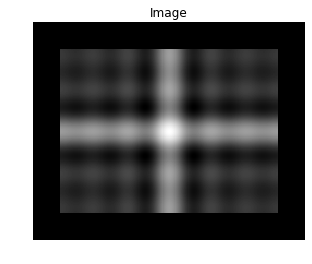


===== Transform Info =====
Transform type: 	TranslationTransform
Dimensions: 		2
Parameters: 		(-5.0, 17.0)



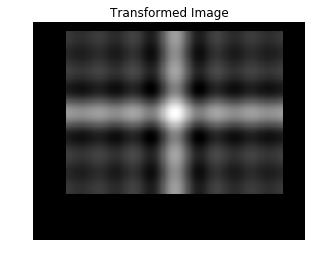

In [3]:
# Read the image
dim = 2 # dimension 2 (images in 2D)

prefix = './images/'
# prefix = '/content/registration_tutorial/images/'

syn = sitk.ReadImage(prefix + 'sinc.png', sitk.sitkFloat64) # load as double
img = sitk.ConstantPad(syn, (25,25), (25,25), 0.0)
print(image_info(img))
imshow_2d(img, 'Image')

# Create the transformation
translation = sitk.TranslationTransform(dim)
translation.SetParameters((-5,17))
print(transform_info(translation))

# Apply the transformation
img_tt = transform_image(img, translation)
imshow_2d(img_tt, 'Transformed Image')

## Utility functions

The next functions are used with the registration algorithm to plot the metric values during the optimization procedure.

In [4]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_register_plot():
    global metric_values
    metric_values = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_register_plot():
    global metric_values
    
    del metric_values
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_register_values(registration_method):
    global metric_values
    
    metric_values.append(registration_method.GetMetricValue())
    
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()

A registration algorithm will use the two images to find the transformation. The next function register two images with the sum of squares difference as metric and the gradient descent as the optimizer.

In [5]:
def registration_ssd(fixed_image, moving_image, transform, 
                    interpolator = sitk.sitkLinear, num_iterations = 50, 
                    learning_rate = 1.5, verbose = True, plot = True):
    '''
    Image regristration with metric sum of squared difference (ssd)
    Input:
        fixed_image: sitk.Image
        moving_image: sitk.Image
    Output:
        sitk.Transform
    '''
    # Define the registration object class
    registration_method = sitk.ImageRegistrationMethod()

    # Set transform, intepolation and metric
    registration_method.SetInitialTransform(transform)
    registration_method.SetInterpolator(interpolator)
    registration_method.SetMetricAsMeanSquares()        # Metric sum of squared difference.
    
    # Set optimizer as gradient descent
    registration_method.SetOptimizerAsGradientDescent(learningRate=learning_rate, 
        numberOfIterations=num_iterations, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift() # Set appropiate scales
    
    # Enable plotting
    if plot:
        registration_method.AddCommand(sitk.sitkStartEvent, start_register_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, end_register_plot)
        registration_method.AddCommand(sitk.sitkIterationEvent, 
                                   lambda: plot_register_values(registration_method))
    
    transform_estimated = registration_method.Execute(fixed_image, moving_image)
    
    # Print the information about the optimization in the registration
    if verbose:
        info = '\n===== Registration Info ====='
        info += '\nFinal metric value: \t' + str(registration_method.GetMetricValue())
        info += '\nLast iteration: \t' + str(registration_method.GetOptimizerIteration())
        info += '\nStop condition: \n'
        info += (str(registration_method.GetOptimizerStopConditionDescription()))
        info += '\n'
        print(info)
    
    return transform_estimated

The registration algorithm is ready to use.

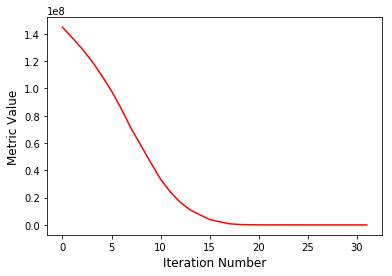


===== Registration Info =====
Final metric value: 	0.22029209038392827
Last iteration: 	32
Stop condition: 
GradientDescentOptimizerv4Template: Convergence checker passed at iteration 32.



In [6]:
# Define the fixed and the moving images
fixed_image = img
moving_image = img_tt

# Create an empty transform
transform = sitk.TranslationTransform(dim)

# Run the registration algorithm
transform_sol = registration_ssd(fixed_image, moving_image, transform)

The solution is the inverse of the expected transformation. In this case, the translation with negative values. The inverse is printed. Compare the initial transform

In [7]:
# Print to compare the applied transform and the solution found by the registration process
print(transform_info(translation))
print(transform_info(transform_sol.GetInverse()))


===== Transform Info =====
Transform type: 	TranslationTransform
Dimensions: 		2
Parameters: 		(-5.0, 17.0)


===== Transform Info =====
Transform type: 	TranslationTransform
Dimensions: 		2
Parameters: 		(-4.999854410663073, 16.999769671426193)



## Visualize Registration

The entire registration process can be visualized in a single image with subplots.
Here, a function to visualize the registration is defined.

In [8]:
def displacement_vectors(size, transform, samples = 30):
    # Create the coordinates
    numSamplesX = samples
    numSamplesY = samples                 
    coordsX = np.linspace(0, size[0]-1, numSamplesX)
    coordsY = np.linspace(0, size[1]-1, numSamplesY)
    XX, YY = np.meshgrid(coordsX, coordsY)

    # Transform points and compute the vectors.
    vectorsX = np.zeros(XX.shape)
    vectorsY = np.zeros(YY.shape)
    for index, value in np.ndenumerate(XX):
        px,py = transform.TransformPoint((value, YY[index]))
        vectorsX[index] = px - value
        vectorsY[index] = py - YY[index]
        
    return XX, YY, vectorsX, vectorsY

def plot_registration(fixed_image, moving_image, transform, samples = 30):
    
    registered_image = transform_image(moving_image, transform)
    
    # Grid generation
    grid = sitk.GridSource(outputPixelType=sitk.sitkFloat32, size=moving_image.GetSize(), 
                           sigma=(0.2, 0.2), gridSpacing=(3, 3), spacing=(0.2,0.2))
    grid.SetSpacing((1.0,1.0))

    registered_grid = transform_image(grid, transform)
    
    XX, YY, vectorsX, vectorsY = displacement_vectors(moving_image.GetSize(), 
                                                      transform, samples = samples)
    
    # Plot all the images
    f, axs = plt.subplots(2,3,figsize=(15,9))
    plt.subplot(231)
    imshow_2d(moving_image, 'Moving Image', show=False)
    plt.subplot(232)
    imshow_2d(fixed_image, 'Fixed Image', show=False)
    plt.subplot(233)
    imshow_2d(registered_image, 'Registered Image', show=False)
    
    ax = plt.subplot(234)
    plt.quiver(XX, YY, vectorsX, vectorsY)
#     plt.xlim(0,fixed_image.GetWidth())
#     plt.ylim(0,fixed_image.GetHeight())
    plt.title('Displacement Vectors')
    plt.axis('off')
    ax.set_aspect(1.0)
    
    plt.subplot(235)
    imshow_2d(fixed_image-registered_image, 'Difference Image', show=False)
    plt.subplot(236)
    imshow_2d(registered_grid, 'Grid Warp', show=False)
    plt.show()

Now, the visualization function is used.

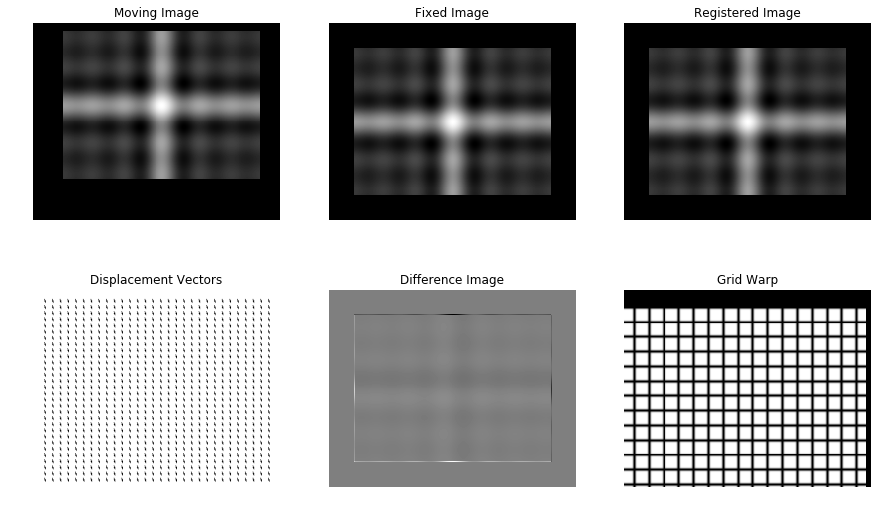

In [9]:
# plot the results in a single plot with subfigures
plot_registration(fixed_image, moving_image, transform_sol)

## Rigid Registration

Here, we run the same synthetic example as before with a rigid transformation.


===== Transform Info =====
Transform type: 	Euler2DTransform
Dimensions: 		2
Parameters: 		(-0.08726646259971647, -5.0, 17.0)



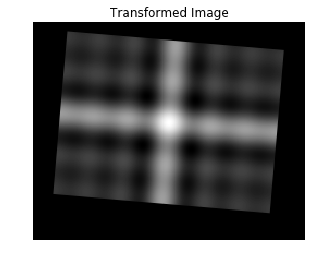

In [10]:
# Create the transformation
rigid = sitk.Euler2DTransform()
rigid.SetParameters((-np.pi/36,-5,17))
print(transform_info(rigid))

# Apply the transformation
img_rt = transform_image(img, rigid)
imshow_2d(img_rt, 'Transformed Image')

The registration algorithm is run again.

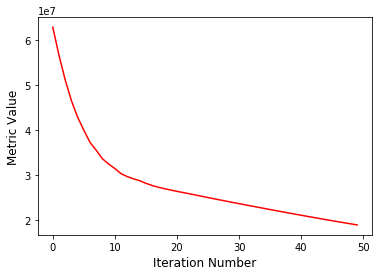


===== Registration Info =====
Final metric value: 	19015900.920874316
Last iteration: 	50
Stop condition: 
GradientDescentOptimizerv4Template: Maximum number of iterations (50) exceeded.



In [11]:
# Define the fixed and moving images
fixed_image = img
moving_image = img_rt

transform = sitk.Euler2DTransform()

# Run the registration algorithm
tr_sol_rigid1 = registration_ssd(fixed_image, moving_image, transform,
                                num_iterations = 50, learning_rate = 1.5)

Observe the original transformation and the found.

In [12]:
# Print to compare the applied transform and the solution found by the registration process
print(transform_info(rigid))
print(transform_info(tr_sol_rigid1.GetInverse()))


===== Transform Info =====
Transform type: 	Euler2DTransform
Dimensions: 		2
Parameters: 		(-0.08726646259971647, -5.0, 17.0)


===== Transform Info =====
Transform type: 	Euler2DTransform
Dimensions: 		2
Parameters: 		(-0.01947974065148573, -0.6320856348160377, 9.791818926979158)



In any registration algorithm it is always necesarry to choose properly the learning rate and number of iterations in the optimizer.

The plot show that the optimization was still decreasing linearly. The termination of the optimizer should show a convergent curve. Change the iteration number and the learning rate to achieve a minimum in the result.

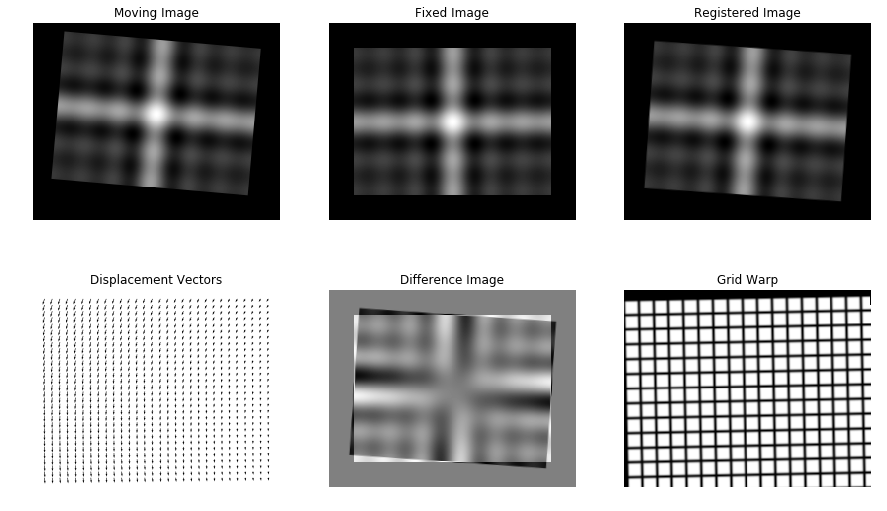

In [13]:
plot_registration(fixed_image, moving_image, tr_sol_rigid1)

The registration fails. It is desirable to debug and try to get the correct answer.

There are two reasons to consider in the failure. 
As we can see in the difference image, the transformation fall into a local minimun. This is probable to happend in any registration procedure.

A registration algorithm heavily depends on initialization. SimpleITK has some methods to initilize a transformation.

The initialization consist in a coarse estimation of the transformation. SimpleITK provides the function sitk.CenteredTransformInitializer with two methods to initilize a transformation. Select between using the geometrical center of the images (GEOMETRY) or using the center of mass given by the image intensities (MOMENTS).

Here, we compute the initial euler transformation based on the center of mass.

In [14]:
# initial_transform = sitk.Euler2DTransform()
# initial_transform.SetIdentity()


initializer = sitk.CenteredTransformInitializer(fixed_image, 
                                                moving_image,
                                                sitk.Euler2DTransform(),
                                                sitk.CenteredTransformInitializerFilter.MOMENTS)
print(transform_info(initializer))


===== Transform Info =====
Transform type: 	Euler2DTransform
Dimensions: 		2
Parameters: 		(0.0, -0.41375067934610854, -8.10902045264342)



Now, we use the initial tranformation in the registration algorithm.

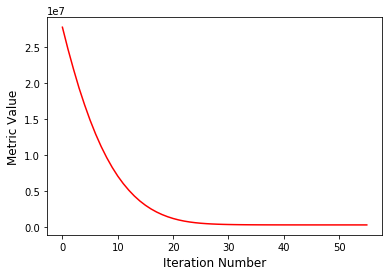


===== Registration Info =====
Final metric value: 	288131.37880878715
Last iteration: 	56
Stop condition: 
GradientDescentOptimizerv4Template: Convergence checker passed at iteration 56.



In [15]:
tr_sol_rigid2 = registration_ssd(fixed_image, moving_image, initializer, num_iterations=70)

Compare the applied transform and the solution found by the registration process

In [16]:
# Print to compare the applied transform and the solution found by the registration process
print(transform_info(rigid))
print(transform_info(tr_sol_rigid2.GetInverse()))


===== Transform Info =====
Transform type: 	Euler2DTransform
Dimensions: 		2
Parameters: 		(-0.08726646259971647, -5.0, 17.0)


===== Transform Info =====
Transform type: 	Euler2DTransform
Dimensions: 		2
Parameters: 		(-0.08720120247458556, 1.1184837734534963, 8.042198700362606)



It can be observed that the registration algorithm converges properly and the angle is correct. Altough the translation is not precisely the original one is somehow approximate. We proceed to visualize the result.

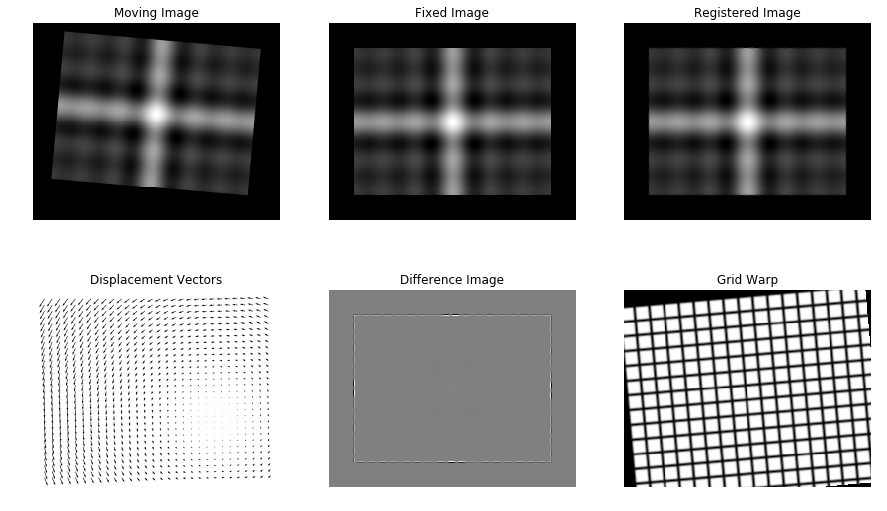

In [17]:
plot_registration(fixed_image, moving_image, tr_sol_rigid2)

## Affine Registration

Now we use a brain image to run the registration. In this case the transformation is affine.


===== Image Information =====
Pixel type: 		64-bit float
Pixel channels: 	1
Dimensions: 		2
Size: 			(221, 257)
Length (mm): 		(1.0, 1.0)
Total Elements: 	56797



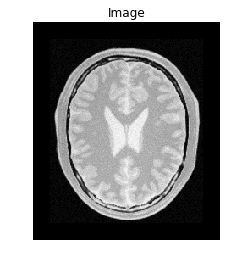


===== Transform Info =====
Transform type: 	AffineTransform
Dimensions: 		2
Parameters: 		(1.0, 0.2, 0.0, 1.0, -20.3, 12.4)



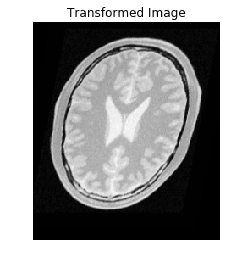

In [18]:
# Read the image
dim = 2 # dimension 2 (images in 2D)

img = sitk.ReadImage(prefix + 'brain.png', sitk.sitkFloat64) # load as double
print(image_info(img))
imshow_2d(img, 'Image')

# Create the transformation
affine_transform = sitk.AffineTransform(dim)
affine_transform.SetParameters((1,0.2,0,1,-20.3,12.4))
print(transform_info(affine_transform))

# Apply the transformation
img_aft = transform_image(img, affine_transform)
imshow_2d(img_aft, 'Transformed Image')

Initialize the transformation

In [19]:
# Define the fixed and moving images
fixed_image = img
moving_image = img_aft

initializer = sitk.CenteredTransformInitializer(fixed_image,
                                                moving_image,
                                                sitk.AffineTransform(dim),
                                                sitk.CenteredTransformInitializerFilter.MOMENTS)
print(transform_info(initializer))


===== Transform Info =====
Transform type: 	AffineTransform
Dimensions: 		2
Parameters: 		(1.0, 0.0, 0.0, 1.0, -3.5209793356506793, -12.348259488400899)



Run the registration algorithm

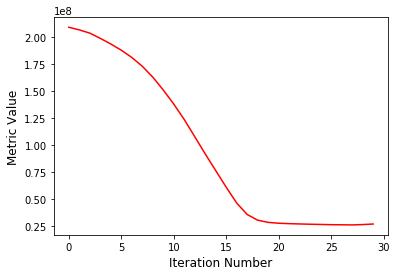


===== Registration Info =====
Final metric value: 	29132753.572661918
Last iteration: 	30
Stop condition: 
GradientDescentOptimizerv4Template: Convergence checker passed at iteration 30.



In [20]:
tr_sol_affine1 = registration_ssd(fixed_image, moving_image, initializer, num_iterations=70)

Compare the original tranformation and the found by the registration algorithm

In [21]:
print(transform_info(affine_transform))
print(transform_info(tr_sol_affine1.GetInverse()))


===== Transform Info =====
Transform type: 	AffineTransform
Dimensions: 		2
Parameters: 		(1.0, 0.2, 0.0, 1.0, -20.3, 12.4)


===== Transform Info =====
Transform type: 	AffineTransform
Dimensions: 		2
Parameters: 		(0.9962345894846831, 0.13543123706962729, 0.09525645555097517, 1.0162275876509632, 4.609208608448984, 12.648569720816056)



Visualize the registration result.

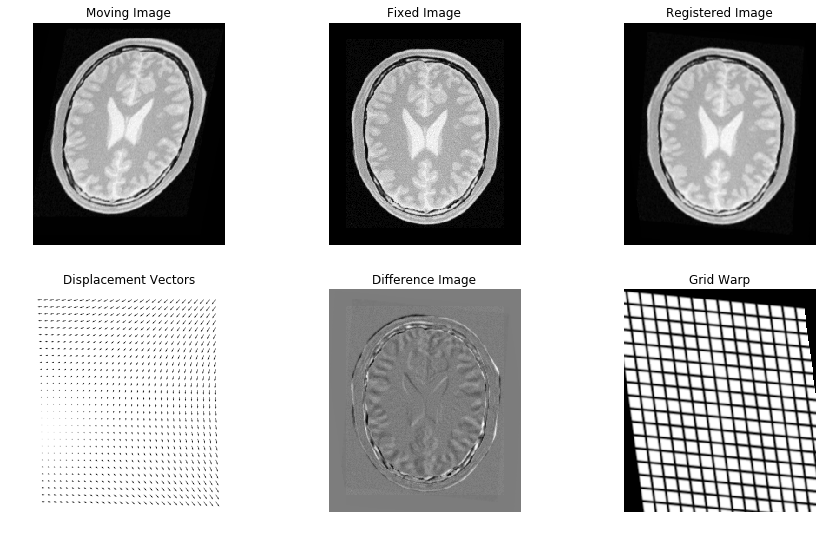

In [22]:
plot_registration(fixed_image, moving_image, tr_sol_affine1)

The affine transformation is close to the expected but in the difference image the misaligment is clear. This is explained because the affine transformation has more variable (degrees of freedom) in comparison to a rigid registration, the result can be less accurate and dificult to optimize. 

## Changing the Similarity Metric and the Optimizer

We define here a new algorithm to show the simplicity sitk.ImageRegistrationMethod. This new algorithm has changed the similarity and the optimizer. This new features are added with simplicity to the algorithm with minor changes to the original code. SimpleITK allows this versatil approach to test multiple variants in the registration process.

The algorithm will use the correlation metric and conjugate gradient descent. With this features we hope to have better results with the previous example.

In [23]:
def registration_cc(fixed_image, moving_image, transform, 
                    interpolator = sitk.sitkLinear, num_iterations = 50, 
                    learning_rate = 1.5, verbose = True, plot = True):
    '''
    Image regristration with correlation metric (cc)
    Input:
        fixed_image: sitk.Image
        moving_image: sitk.Image
    Output:
        sitk.Transform
    '''
    # Define the registration object class
    registration_method = sitk.ImageRegistrationMethod()

    # Set transform, intepolation and metric
    registration_method.SetInitialTransform(transform)
    registration_method.SetInterpolator(interpolator)
    registration_method.SetMetricAsCorrelation()        # Metric correlation.
    
    # Set optimizer as conjugate gradient descent
    registration_method.SetOptimizerAsConjugateGradientLineSearch(learningRate=learning_rate, 
        numberOfIterations=num_iterations, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift() # Set appropiate scales
    
    # Enable plotting
    if plot:
        registration_method.AddCommand(sitk.sitkStartEvent, start_register_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, end_register_plot)
        registration_method.AddCommand(sitk.sitkIterationEvent, 
                                   lambda: plot_register_values(registration_method))
    
    transform_estimated = registration_method.Execute(fixed_image, moving_image)
    
    # Print the information about the optimization in the registration
    if verbose:
        info = '\n===== Registration Info ====='
        info += '\nFinal metric value: \t' + str(registration_method.GetMetricValue())
        info += '\nLast iteration: \t' + str(registration_method.GetOptimizerIteration())
        info += '\nStop condition: \n'
        info += (str(registration_method.GetOptimizerStopConditionDescription()))
        info += '\n'
        print(info)
    
    return transform_estimated

Again, we run the initial transform estimation

In [24]:

initial_cc = sitk.CenteredTransformInitializer(fixed_image,
                                                moving_image,
                                                sitk.AffineTransform(dim),
                                                sitk.CenteredTransformInitializerFilter.MOMENTS)
print(transform_info(initial_cc))



===== Transform Info =====
Transform type: 	AffineTransform
Dimensions: 		2
Parameters: 		(1.0, 0.0, 0.0, 1.0, -3.5209793356506793, -12.348259488400899)



Run the new registration algorithm.

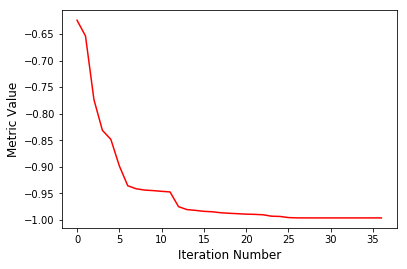


===== Registration Info =====
Final metric value: 	-0.9964013043752709
Last iteration: 	37
Stop condition: 
ConjugateGradientLineSearchOptimizerv4Template: Convergence checker passed at iteration 37.



In [25]:
tr_sol_affine2 = registration_cc(fixed_image, moving_image, initial_cc,
                                 interpolator = sitk.sitkBSpline, num_iterations=70)

The registration algorithm is more time consuming. Since we are using a metric with more computational requirement, a better interpolator and a more accurate optimizer.

In [26]:
print(transform_info(affine_transform))
print(transform_info(tr_sol_affine2.GetInverse()))


===== Transform Info =====
Transform type: 	AffineTransform
Dimensions: 		2
Parameters: 		(1.0, 0.2, 0.0, 1.0, -20.3, 12.4)


===== Transform Info =====
Transform type: 	AffineTransform
Dimensions: 		2
Parameters: 		(1.0002341779954573, 0.20030518618607202, -0.00021898700465017296, 0.9998620321579602, 6.025821804000223, 12.380816079464665)



The solution is more accurate than before. The affine scales and shears are more approximate to the real ones. We can visualize the results.

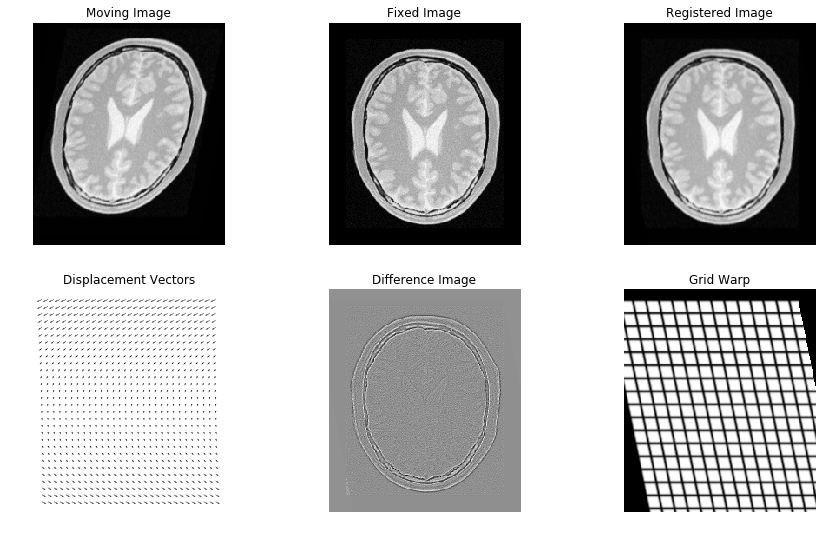

In [27]:
plot_registration(fixed_image, moving_image, tr_sol_affine2)